In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(mes_val_for_diff=18,mes_val_for_same=0.8,conf_val_for_diff=0.3,conf_val_for_same=0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 365.04it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 4830.08it/s]


absolute alignment indicates number: 123 label diff indicates number: 10007 confidence diff indicates number: 12 high distance number: 8025


In [2]:
X = ref_train_data
Y = tar_train_data

In [14]:
from AlignVis.ApproximateRepGenerator import ApproximateRefGenerator
aeg = ApproximateRefGenerator(ref_provider=ref_provider, tar_provider=tar_provider, REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH, tar_model=tar_model, ref_model=ref_model,DEVICE=DEVICE)
high_discrepancy_representation_set = aeg.getHighDiscrepancyRepresentationSet(percentile=95)

100%|██████████| 250/250 [00:00<00:00, 4507.48it/s]


Number of samples with highest transformation degree: 2500


In [15]:
newRep = aeg.generate_representation_by_cka(X[high_discrepancy_representation_set], Y[high_discrepancy_representation_set],epoch=100)

100%|██████████| 13/13 [00:00<00:00, 9681.45it/s]


Iteration 99: CKA loss = 0.0571900010
               Prediction loss = 89.5425720215
               KNN loss = 0.6015200019
              KNN loss with ref = 0.0000000000
               Confidence different loss = 9.5862789154


In [16]:
print('reference predict res: ', ref_prediction_res[high_discrepancy_representation_set])
print('adjusetd ref  predict res: ', ref_provider.get_pred(200, newRep).argmax(axis=1))
print('adjusetd ref  predict in tar res: ', tar_provider.get_pred(200, newRep).argmax(axis=1))
print('target        predict res: ', tar_prediction_res[high_discrepancy_representation_set])

reference predict res:  [1 7 0 ... 4 8 1]


100%|██████████| 13/13 [00:00<00:00, 9205.80it/s]


adjusetd ref  predict res:  [1 7 0 ... 4 8 1]


100%|██████████| 13/13 [00:00<00:00, 8653.54it/s]

adjusetd ref  predict in tar res:  [1 1 3 ... 4 8 5]
target        predict res:  [1 7 0 ... 4 8 1]


In [17]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('CKA between ref vs tar is:',np_cka.kernel_CKA(ref_train_data[high_discrepancy_representation_set],tar_train_data[high_discrepancy_representation_set]))
print('CKA between ref vs tar is:',np_cka.kernel_CKA(newRep,ref_train_data[high_discrepancy_representation_set]))
print('CKA between new vs tar is:',np_cka.kernel_CKA(newRep,tar_train_data[high_discrepancy_representation_set]))

CKA between ref vs tar is: 0.9307511046060919
CKA between ref vs tar is: 0.9961444572736401
CKA between new vs tar is: 0.9429339788338444


In [22]:

print(f"{len(high_distance_indicates)} samples in high prediction MAE set")
in_both_arrays = np.in1d(high_discrepancy_representation_set, high_distance_indicates)

print(f"{np.count_nonzero(in_both_arrays)}/{len(high_distance_indicates)} samples of high prediction MAE are present in high_discrepancy_representation_set.")


print(f"{len(absolute_alignment_indicates)} samples in absolute alignmeny set")
in_both_arrays = np.in1d(high_discrepancy_representation_set, absolute_alignment_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(absolute_alignment_indicates)} samples of absolute_alignment_indicates are present in high_discrepancy_representation_set.")


print(f"{len(predict_label_diff_indicates)} samples in predict_label_diff set")
in_both_arrays = np.in1d(high_discrepancy_representation_set, predict_label_diff_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(predict_label_diff_indicates)} samples of predict_label_diff are present in high_discrepancy_representation_set.")
in_both_arrays = np.in1d(high_distance_indicates, predict_label_diff_indicates)
print(f"{np.count_nonzero(in_both_arrays)}/{len(predict_label_diff_indicates)} samples of predict_label_diff are present in high prediction MAE set.")


8025 samples in high prediction MAE set
167/8025 samples of high prediction MAE are present in high_discrepancy_representation_set.
123 samples in absolute alignmeny set
19/123 samples of absolute_alignment_indicates are present in high_discrepancy_representation_set.
10007 samples in predict_label_diff set
161/10007 samples of predict_label_diff are present in high_discrepancy_representation_set.
7944/10007 samples of predict_label_diff are present in high prediction MAE set.


In [23]:
new_ref_representations = ref_provider.train_representation(200)
for i in range(len(high_discrepancy_representation_set)):
    index = high_discrepancy_representation_set[i]
    new_ref_representations[index] = newRep[i]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9797.14it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

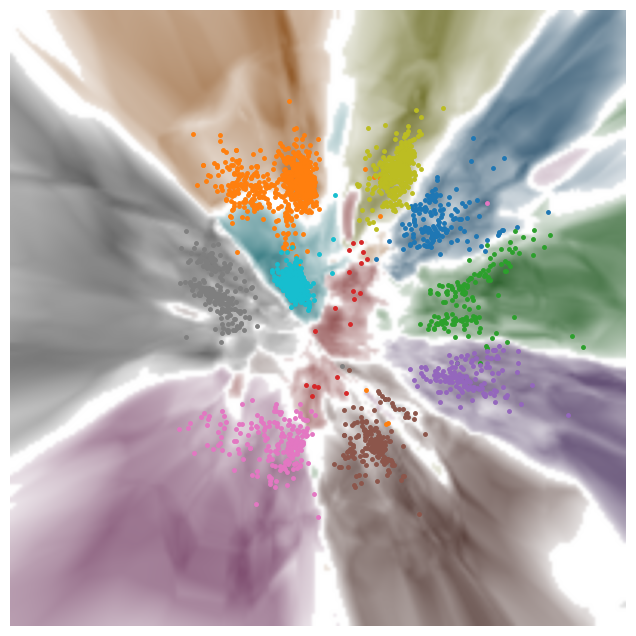

In [26]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(new_ref_representations, I), projector, 200,[high_discrepancy_representation_set],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 13/13 [00:00<00:00, 11284.34it/s]


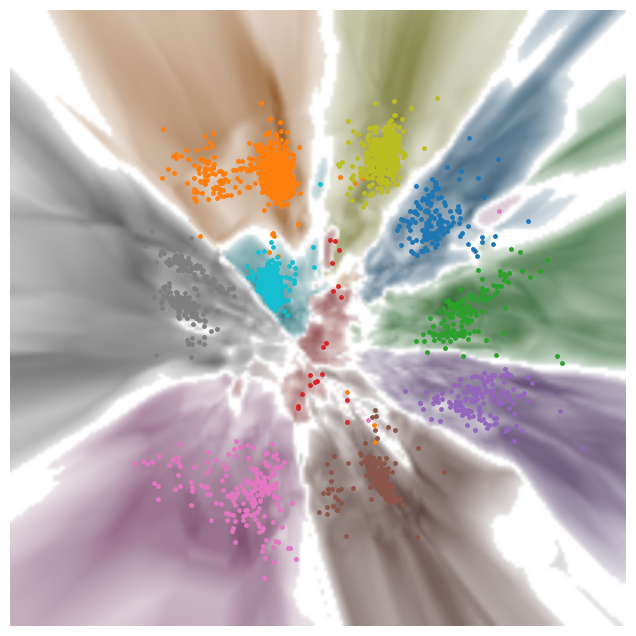

In [27]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data, I), projector, 200,[high_discrepancy_representation_set],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [10]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment

alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
S_n = alignment_n.align_embeddings_batch(X,Y,train_steps=1000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-8,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 93918272.0 loss2 {tensor(0.7387, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8720, requires_grad=True)}
batch_idx 199,iteration 199, loss1 279.47735595703125 loss2 {tensor(0.4943, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5010, requires_grad=True)}
batch_idx 398,iteration 398, loss1 213.11524963378906 loss2 {tensor(0.4062, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4810, requires_grad=True)}
batch_idx 97,iteration 597, loss1 197.8415985107422 loss2 {tensor(0.4070, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4800, requires_grad=True)}
batch_idx 296,iteration 796, loss1 188.1884002685547 loss2 {tensor(0.3930, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4590, requires_grad=True)}
batch_idx 495,iteration 995, loss1 168.54605102539062 loss2 {tensor(0.3258, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4310, requires_grad=True)}


In [8]:
R_n = alignment_n.align_embeddings_batch(Y,X,train_steps=5000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-8,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 97477712.0 loss2 {tensor(0.7641, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8690, requires_grad=True)}
batch_idx 199,iteration 199, loss1 308.41455078125 loss2 {tensor(0.5941, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5440, requires_grad=True)}
batch_idx 398,iteration 398, loss1 264.4737243652344 loss2 {tensor(0.5136, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5590, requires_grad=True)}
batch_idx 97,iteration 597, loss1 239.28549194335938 loss2 {tensor(0.4839, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5260, requires_grad=True)}
batch_idx 296,iteration 796, loss1 196.9774627685547 loss2 {tensor(0.3806, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4570, requires_grad=True)}
batch_idx 495,iteration 995, loss1 203.7021942138672 loss2 {tensor(0.4131, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4770, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 195.67933654785156 loss2 {tensor(0.4133, grad_fn=<AddBackward0>)} neibour_los

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9646.74it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

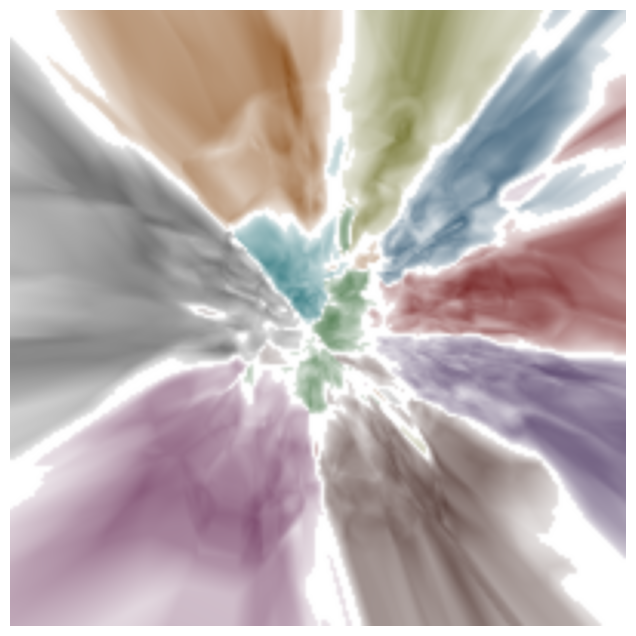

In [28]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_n.detach().numpy(),I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[[]],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))